# MultIVAP CIFAR-10 example

This notebook demonstrates basic usage of our MultIVAP algorithm on a convolutional neural network for the CIFAR-10 data set.

First, we import the necessary modules:

In [1]:
import cifar10
import numpy as np
import keras
import matplotlib.pyplot as plt

from multivap import MultIVAP
from tabulate import tabulate
from whitebox import WhiteboxAttack

Using TensorFlow backend.


We define a couple of utility functions for data normalization and visualization of results:

In [2]:
def normalize(arr):
    min_val, max_val = arr.min(), arr.max()
    arr -= min_val
    arr /= max_val - min_val
    return arr

def heatmap(cm, xlabel='Predicted class', ylabel='True class', names=None):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='gray_r')
    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))
    ax.set_xticklabels([names[i] if names is not None else i+1 for i in range(cm.shape[0])])
    ax.set_yticklabels([names[i] if names is not None else i+1 for i in range(cm.shape[1])])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if names is not None:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, int(cm[i, j]), ha="center", va="center", color="red")
    fig.tight_layout()

def print_metrics(metrics):
    print(tabulate([
        ['Jaccard index', metrics.jac],
        ['Efficiency', '{} <= {} <= {}'.format(metrics.eff_lower, metrics.eff, metrics.eff_upper)],
        ['Rejection', metrics.rej],
        ['TRR', metrics.trr],
        ['FRR', metrics.frr]
    ]))

Now we can load the data and prepare the training, calibration, validation and test sets:

In [3]:
# load data
x_train, y_train, x_test, y_test = cifar10.load_datasets()

# normalize the data set
x_train = normalize(x_train.astype(np.float64))
x_test = normalize(x_test.astype(np.float64))

# splits for proper training, proper testing, calibration and validation sets
idx = int(.8*x_train.shape[0])
x_proper_train, y_proper_train = x_train[:idx], y_train[:idx]
x_calib, y_calib = x_train[idx:], y_train[idx:]

idx = int(.8*x_test.shape[0])
x_proper_test, y_proper_test = x_test[:idx], y_test[:idx]
x_valid, y_valid = x_test[idx:], y_test[idx:]

print('Training samples: {}'.format(x_proper_train.shape))
print('Calibration samples: {}'.format(x_calib.shape))
print('Test samples: {}'.format(x_test.shape))
print('Validation samples: {}'.format(x_valid.shape))

Training samples: (40000, 32, 32, 3)
Calibration samples: (10000, 32, 32, 3)
Test samples: (10000, 32, 32, 3)
Validation samples: (2000, 32, 32, 3)


We then create and fit the model as specified in `cifar10.py`:

In [4]:
model = cifar10.create_model()
model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=cifar10.get_optimizer(),
                metrics=['accuracy'])
model.fit(x_proper_train, y_proper_train,
        batch_size=128,
        epochs=10,
        verbose=1,
        validation_data=(x_valid, y_valid))

W0214 13:30:37.154367 140182244149056 deprecation_wrapper.py:119] From /scratch/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0214 13:30:38.949012 140182244149056 deprecation_wrapper.py:119] From /scratch/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 40000 samples, validate on 2000 samples
Epoch 1/10
40000/40000 [==============================] - 7s 182us/step - loss: 1.6282 - accuracy: 0.4023 - val_loss: 1.2568 - val_accuracy: 0.5390
Epoch 2/10
40000/40000 [==============================] - 6s 139us/step - loss: 1.2239 - accuracy: 0.5628 - val_loss: 1.0867 - val_accuracy: 0.6085
Epoch 3/10
40000/40000 [==============================] - 5s 136us/step - loss: 1.0305 - accuracy: 0.6373 - val_loss: 0.9486 - val_accuracy: 0.6700
Epoch 4/10
40000/40000 [==============================] - 5s 137us/step - loss: 0.9035 - accuracy: 0.6827 - val_loss: 0.8602 - val_accuracy: 0.6980
Epoch 5/10
40000/40000 [==============================] - 5s 135us/step - loss: 0.7853 - accuracy: 0.7245 - val_loss: 0.8077 - val_accuracy: 0.7200
Epoch 6/10
40000/40000 [==============================] - 5s 137us/step - loss: 0.7081 - accuracy: 0.7531 - val_loss: 0.7643 - val_accuracy: 0.7280
Epoch 7/10
40000/40000 [==============================] - 6s 13

Once the model is trained, we can create an instance of the MultIVAP class. To do so, we must pass the underlying model, calibration data set and the number of classes. The MultIVAP will then be calibrated on this data:

In [5]:
multivap = MultIVAP(model, x_calib, y_calib, y_test.shape[1])

Using the held-out validation data set, the significance level $\varepsilon$ can be tuned so that the predictive efficiency is as close to one as possible:

In [6]:
eps, _ = multivap.tune(x_valid)
print('Significance level: {}'.format(eps))

Significance level: 0.21739214658737183


We now evaluate the performance of the tuned MultIVAP on the regular test data:

-------------  ----------------------
Jaccard index  0.6330625
Efficiency     0.0 <= 1.020375 <= 2.0
Rejection      0.14975
TRR            0.35714285714285715
FRR            0.08867313915857605
-------------  ----------------------


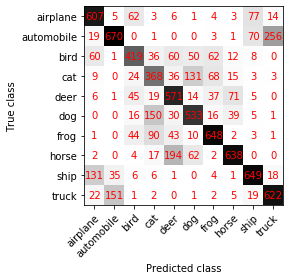

In [7]:
cm, metrics = multivap.evaluate(x_proper_test, y_proper_test, eps)
print_metrics(metrics)
heatmap(cm, names=cifar10.names)

## White-box adversarial attack

We also demonstrate how to use our custom white-box attack to generate adversarial examples for the MultIVAP. We first instantiate the attack with the MultIVAP, the underlying model, the calibration data and the batch size:

In [8]:
whitebox = WhiteboxAttack(multivap, model, x_calib, y_calib, batch_size=128)

W0214 13:33:48.266425 140182244149056 deprecation_wrapper.py:119] From /home/jpeck/multivap/whitebox.py:26: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0214 13:33:48.266994 140182244149056 deprecation_wrapper.py:119] From /home/jpeck/multivap/whitebox.py:26: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0214 13:33:48.267774 140182244149056 deprecation_wrapper.py:119] From /home/jpeck/multivap/whitebox.py:27: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0214 13:33:48.271901 140182244149056 deprecation_wrapper.py:119] From /home/jpeck/multivap/whitebox.py:30: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0214 13:33:48.272760 140182244149056 deprecation.py:506] From /scratch/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) 

Generating adversarial examples is then easily done as follows:

In [9]:
x_advs, flags = whitebox.attack(x_proper_test, y_proper_test, eta=0.03, beta=eps, its=100)

100%|██████████| 62/62 [1:03:49<00:00, 52.30s/it]


The arrays `x_advs` and `flags` contain the actual adversarial examples and flags indicating which adversarials count as a success. This allows us to easily compute the success rate:

In [10]:
print('Success rate: {}\n'.format(flags.mean()))

Success rate: 0.219

